# Capstone_Project_Data_Exploratory_Analysis

#### Project Summary (describe the project at a high level)

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [1]:
# import all libraries and install the packages 
import pandas as pd, re
import re, os
import configparser
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sb
% matplotlib inline  
from datetime import datetime
from pyspark.sql.functions import udf, col, to_timestamp, monotonically_increasing_id
from pyspark.sql.functions import year, month, dayofmonth, hour, weekofyear, date_format


### Step 1: Scope the Project and Gather Data

#### Scope 
Explain what you plan to do in the project in more detail. What data do you use? What is your end solution look like? What tools did you use? etc>   ( choose some tasks after knowing the datasets better) 
* which coutry sends the most visitors to US in year 2016? 
* which cities in US attract the most visitors in year 2016 ? 
* which visa type is the most popular in 2016 ? 
* Which race has the most number of immigrants to US?


#### Tools :
Redshift , S3 , Spark

#### Describe and Gather Data (2 datasets)
* I94 immigration data: This data comes from the US National Tourism and Trade Office. A data dictionary is included in the workspace. 
* data source:  https://travel.trade.gov/research/reports/i94/historical/2016.html

  
* U.S. City Demographic Data: This dataset contains information about the demographics of all US cities and census-designated places with a population greater or equal to 65,000. This data comes from the US Census Bureau's 2015 American Community Survey. It comes with 12 columns.
* data source: https://public.opendatasoft.com/explore/dataset/us-cities-demographics/export/


### Step 2 Explore Sample data for each dataset 

##### (1). I94 dataset

In [2]:
# Read in the data here
# take a look at the sample data in csv format before reading it all in
fname_i94 = '../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat'
df_i94 = pd.read_sas(fname_i94, 'sas7bdat', encoding="ISO-8859-1")

In [3]:
df_i94.head()

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,6.0,2016.0,4.0,692.0,692.0,XXX,20573.0,NaN,NaN,NaN,...,U,NaN,1979.0,10282016,NaN,NaN,NaN,1.897628e+09,NaN,B2
1,7.0,2016.0,4.0,254.0,276.0,ATL,20551.0,1.0,AL,NaN,...,Y,NaN,1991.0,D/S,M,NaN,NaN,3.736796e+09,00296,F1
2,15.0,2016.0,4.0,101.0,101.0,WAS,20545.0,1.0,MI,20691.0,...,NaN,M,1961.0,09302016,M,NaN,OS,6.666432e+08,93,B2
3,16.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,...,NaN,M,1988.0,09302016,NaN,NaN,AA,9.246846e+10,00199,B2
4,17.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,...,NaN,M,2012.0,09302016,NaN,NaN,AA,9.246846e+10,00199,B2


##### (2). Land temperature data

In [4]:
fname_temp = '../../data2/GlobalLandTemperaturesByCity.csv'
df_temp = pd.read_csv(fname_temp)

In [5]:
df_temp.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


##### (3). Cities demographics data

In [7]:
fname_city = 'us-cities-demographics.csv'
df_city = pd.read_csv(fname_city, delimiter = ";")    # origianl file is semi colon separated 

In [8]:
df_city.head()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402


##### (4). Aiport code data

In [9]:
fname_airport = 'airport-codes.csv'
df_airport = pd.read_csv(fname_airport)

In [10]:
df_airport.head()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,"-91.254898, 35.6087"



##### Identify data quality issues, like missing values, duplicate data, etc.

Major attributes for immigration data: 
    
  * i94yr = 4 digit year
  * i94mon = numeric month
  * i94cit = 3 digit code of origin city
  * i94port = 3 character code of destination USA city
  * arrdate = arrival date in the USA
  * i94mode = 1 digit travel code
  * depdate = departure date from the USA
  * i94visa = reason for immigration

In [11]:
df_i94.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3096313 entries, 0 to 3096312
Data columns (total 28 columns):
cicid       float64
i94yr       float64
i94mon      float64
i94cit      float64
i94res      float64
i94port     object
arrdate     float64
i94mode     float64
i94addr     object
depdate     float64
i94bir      float64
i94visa     float64
count       float64
dtadfile    object
visapost    object
occup       object
entdepa     object
entdepd     object
entdepu     object
matflag     object
biryear     float64
dtaddto     object
gender      object
insnum      object
airline     object
admnum      float64
fltno       object
visatype    object
dtypes: float64(13), object(15)
memory usage: 661.4+ MB


There are 3096313 entries and 28 columns. There are some issues with the data type because there are only float and object two data types. 

In [12]:
df_i94.duplicated().sum()

0

In [13]:
df_i94.isnull().sum()

cicid             0
i94yr             0
i94mon            0
i94cit            0
i94res            0
i94port           0
arrdate           0
i94mode         239
i94addr      152372
depdate      142457
i94bir          802
i94visa           0
count             0
dtadfile          1
visapost    1881250
occup       3088187
entdepa         238
entdepd      138429
entdepu     3095921
matflag      138429
biryear         802
dtaddto         477
gender       414269
insnum      2982605
airline       83627
admnum            0
fltno         19549
visatype          0
dtype: int64

There are no null values in arrdate but there are a large number of null values in depdate

In [14]:
df_i94.nunique()

cicid       3096313
i94yr             1
i94mon            1
i94cit          243
i94res          229
i94port         299
arrdate          30
i94mode           4
i94addr         458
depdate         235
i94bir          112
i94visa           3
count             1
dtadfile        117
visapost        530
occup           111
entdepa          13
entdepd          12
entdepu           2
matflag           1
biryear         112
dtaddto         777
gender            4
insnum         1913
airline         534
admnum      3075579
fltno          7152
visatype         17
dtype: int64

In [15]:
df_i94['visatype'].value_counts()

WT     1309059
B2     1117897
WB      282983
B1      212410
GMT      89133
F1       39016
E2       19383
CP       14758
E1        3743
I         3176
F2        2984
M1        1317
I1         234
GMB        150
M2          49
SBP         11
CPL         10
Name: visatype, dtype: int64

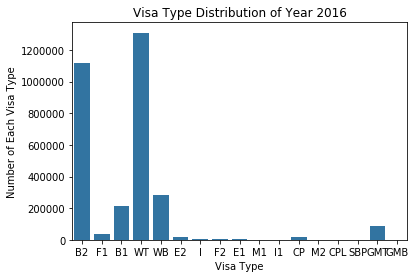

In [16]:
base_color = sb.color_palette()[0]
sb.countplot( data = df_i94 , x ='visatype' , color = base_color )
plt.title('Visa Type Distribution of Year 2016')
plt.xlabel('Visa Type')
plt.ylabel('Number of Each Visa Type');

There are 17 different visa types in this data set. From the graph , we can see the top 2 are WT and B2. They leave other visa types far behind.

* B-2 is a visa type which is generally for pleasure, tourism, or medical treatment.
* WT status allows citizens of a limited number of countries to visit the United States for up to 90 days without a B-1 visa under the Visa Waiver Program. 

In [17]:
df_i94['gender'].value_counts()

M    1377224
F    1302743
X       1610
U        467
Name: gender, dtype: int64

In [18]:
df_i94['occup'].value_counts()

STU    4719
OTH     661
NRR     345
MKT     280
EXA     196
GLS     189
ULS     175
ADM     125
TIE     124
MVC     110
ENO      60
CEO      56
TIP      52
RET      50
CMP      47
LLJ      46
UNP      45
PHS      45
HMK      40
TCC      32
CPA      31
ACH      29
EMC      29
TTE      28
TCH      26
RPT      25
999      25
EIN      25
WTR      21
ECV      20
       ... 
SVC       3
ODS       3
REI       2
FLG       2
CLN       2
PSS       2
DVM       2
ENP       2
RHC       2
AST       2
049       2
PSV       2
HFM       2
CHE       2
HSW       2
ORS       1
POD       1
MTH       1
300       1
LAC       1
ECO       1
DOC       1
101       1
EDR       1
SCP       1
SLS       1
RNS       1
ENV       1
SCS       1
BUG       1
Name: occup, Length: 111, dtype: int64

An interesting finding is that more male immigrants than male immigrants

In [19]:
df_i94['i94yr'].value_counts()
# sample data is for year 2016

2016.0    3096313
Name: i94yr, dtype: int64

In [20]:
df_i94['i94mon'].value_counts()
# the sample data is for April

4.0    3096313
Name: i94mon, dtype: int64

In [21]:
df_i94['biryear'].value_counts()


1986.0    71958
1983.0    70415
1985.0    70409
1982.0    70251
1984.0    69809
1981.0    69626
1980.0    67960
1987.0    67762
1976.0    66568
1979.0    66494
1988.0    65566
1978.0    64262
1977.0    63035
1975.0    62622
1974.0    62150
1971.0    62075
1972.0    62001
1973.0    61430
1989.0    60340
1970.0    59730
1966.0    58946
1969.0    58127
1968.0    57420
1965.0    57312
1964.0    56579
1967.0    56041
1963.0    55673
1990.0    54301
1962.0    53865
1961.0    50288
          ...  
1933.0     2965
1932.0     2500
1931.0     1999
1930.0     1594
1929.0     1204
1928.0      884
2016.0      765
1927.0      638
1926.0      463
1925.0      319
1924.0      241
1923.0      185
1922.0      104
1921.0       88
1919.0       52
1920.0       46
1918.0       26
1916.0       24
1917.0       19
1914.0        4
1907.0        2
1915.0        2
1911.0        2
1908.0        2
1905.0        1
1906.0        1
2019.0        1
1909.0        1
1913.0        1
1902.0        1
Name: biryear, Length: 1

From the counts, we can see that most visitors were in their 30s 

In [22]:
df_i94['biryear'].min()

1902.0

In [23]:
df_i94['biryear'].max()

2019.0

incorrect data:  birth year shows 2019 but this data is for 2016

In [24]:
df_i94['airline'].value_counts() 

AA     310091
UA     264271
DL     252526
BA     190997
LH     120556
VS     113384
AF      81113
KE      71047
JL      69075
AM      60307
EK      55800
CM      49990
B6      49265
AV      48921
JJ      46277
LA      43111
QF      41945
NH      40665
KL      39978
SK      39802
DY      37932
Y4      35250
OZ      35043
LX      33727
CX      33096
HA      32154
QR      29189
MU      28717
TK      27567
CA      26012
        ...  
692         1
881         1
X3          1
EC          1
NA          1
OF          1
13          1
T1G         1
UT          1
15          1
YC          1
N7          1
A1B         1
NRL         1
81          1
DI          1
BO          1
Q2          1
802         1
N5          1
MX          1
203         1
KJ          1
L6K         1
ZI          1
62A         1
B1M         1
CEY         1
D9          1
635         1
Name: airline, Length: 534, dtype: int64

error : 512, 078,020 are not an airline 

In [25]:
df_city.duplicated().sum()

0

In [26]:
df_city.isnull().sum()

City                       0
State                      0
Median Age                 0
Male Population            3
Female Population          3
Total Population           0
Number of Veterans        13
Foreign-born              13
Average Household Size    16
State Code                 0
Race                       0
Count                      0
dtype: int64

In [27]:
df_city.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2891 entries, 0 to 2890
Data columns (total 12 columns):
City                      2891 non-null object
State                     2891 non-null object
Median Age                2891 non-null float64
Male Population           2888 non-null float64
Female Population         2888 non-null float64
Total Population          2891 non-null int64
Number of Veterans        2878 non-null float64
Foreign-born              2878 non-null float64
Average Household Size    2875 non-null float64
State Code                2891 non-null object
Race                      2891 non-null object
Count                     2891 non-null int64
dtypes: float64(6), int64(2), object(4)
memory usage: 271.1+ KB


#### Summary of major data issues

(1) Quality issues (content issues ) 

The issues lying within the immigration data:
* data type : there are only two data types: object and float (year, month, arrdate, depdate, biryear should not be float but integer)
* incorrect date : arrdate 
* invalid value for i94port : i94port XXX
* incorrect birth year : 2019 , this data was for 2016 
* Invalid Airline: 512 not an airline

The issues lying within the U.S. City Demographic data: 
* data type: incorrect float type (Male Population, Female Population, Number of Veterans, Foreign-born)

(2). Tidiness issues (structure issues)

The issues lying within the immigration data: 

The issues lying within the U.S. City Demographic data: this data is pretty clean 

#### Cleaning Steps
Document steps necessary to clean the data

for I94 data set: ( the major issue fix would lie in this dataset)
* (1). i94yr  change the data type from string to int
* (2). i94mon change the data type from string to int
* (3). i94cit  change the data type from float to int
* (4). arrdate and depdate change the data type from float to integer
* (5). i94mode change data type from float to int
* (6). i94visa change data type from float to int
* (7). Set i94yr which are greater than 2016 to null because it is 2016 data. any arrive year greater than 2016 is invalid.
* (8). Drop the entries which are null 



In [28]:
# Data cleaning
# make a copy first 
df_i94_copy = df_i94.copy()
df_city_copy = df_city.copy()

In [31]:
def data_clean(df):
    '''
    This function takes dataframe as input 
    Returns a clean dataframe with the correct data types and valid i94yr 
    
    '''
    # change the data type from float to integer 
    df['i94yr'] = df['i94yr'].astype(int)     
    df['i94mon'] = df['i94mon'].astype(int)
    df['i94cit'] = df['i94cit'].astype(int)
    df['i94port'] = df['i94port'].astype(int)
    df['i94visa'] = df['i94visa'].astype(int)
    df['i94mode'] = df['i94mode'].astype(int)
    
    # remove the i94yr greater than 2016 and 
    df = df.filter( df.i94yr < 2016)
    
    return df

In [ ]:
df_i94_copy = data_clean(df_i94_copy )

In [ ]:
df_i94_copy.head()

### Step 3: Define the Data Model   ( star schema, dimension tables and fact table  , several tables can extract from one dataset) 
#### 3.1 Conceptual Data Model
I chose the city dataset and immigration dataset 
A star schema is built with a fact table and multiple dimension table 
*************************************  here need to complete
#### 3.2 Mapping Out Data Pipelines
List the steps necessary to pipeline the data into the chosen data model

In [ ]:
# set up the configration 
config = configparser.ConfigParser()

# read in credentials for S3 full access 
config.read('dl.cfg')
os.environ['AWS_ACCESS_KEY_ID'] = config.get('CREDENTIALS', 'AWS_ACCESS_KEY_ID' )
os.environ['AWS_SECRET_ACCESS_KEY'] = config.get('CREDENTIALS', 'AWS_SECRET_ACCESS_KEY')


In [ ]:
# initialize a spark session on aws hadoop
# return spark session
def create_spark_session():
    spark = SparkSession \
        .builder \
        .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:2.7.0") \
        .getOrCreate()
    return spark

In [22]:
def process_city_data(spark, input_data, output_data):
    '''
    Read in city data from S3
    transform the data to create dimensional tables
    load the data back to S3 in parquet files  
    
    input: spark session, input data in csv format and output data as s3 path    
    '''
    
    # get filepath to city data file
    city_data = input_data + "city_data/us_cities_demographics.csv"
    
    # read song data file
    city_df = spark.read.format("csv").option("header", "true").load(city_data)
    print("City data schema:")
    city_df.printSchema()
    
    # quality check 
    print("Total records in City data is: ")
    print(city_df.count())

    # extract columns to create city table
    # data cleaning by dropping duplicates in this process 
    city_table = city_df.select(['city','state', 'median_age','male_pop','female_pop','total_pop', 'num_of_veteran',
                                 'foreign_born', 'ave_household_size', 'race', ' count' ]).dropDuplicates().collect()
    
    # write artists table to parquet files
    city_table.write.mode("append").partitionBy("i94cit").parquet(output_data + "/city_table.parquet")

In [23]:
def process_immigration_data(spark, input_data, output_data):
    
    '''
    Read in immigration data from S3
    transform the data to create dimensional tables
    load the data back to S3 in parquet files     
    '''
    
    # get filepath to immigration data file
    # try with one file
    #immigration_data = input_data + "i94_apr16_sub.sas7bdat"
    immigration_data = input_data + "*.sas7bdat"

    # Read I94 data into Spark
    df_immigration = spark.read.format('com.github.saurfang.sas.spark').load(immigration_data)

    # Filter out entries where i94port is invalid
    df_immigration = df_immigration.filter(df_immigration.i94port.isin(list(valid_i94port.keys())))

    # Extract columns for immigration dimension table
    immigration_table = df_immigration.select(["i94yr", "i94mon", "i94cit", "i94port", "arrdate", "i94mode", "depdate", "i94visa"])

    # Write immigration dimension table to parquet files partitioned by i94port
    immigration_table.write.mode("append").partitionBy("i94cit").parquet("/results/immigration.parquet")

In [ ]:
def quality_check(df, description):
    '''
    Input: Spark dataframe, description of Spark datafram
    
    Output: Print outcome of data quality check
    
    '''
    
    result = df.count()
    if result == 0:
        print("Data quality check failed for {} with zero records".format(description))
    else:
        print("Data quality check passed for {} with {} records".format(description, result))
    return 0

# Perform data quality check
quality_check(df_immigration, "immigration table")
quality_check(df_city, "temperature table")

In [ ]:
def main():
    spark = create_spark_session()
    input_data = "s3a://dend-capstone-project-xzhou/"
    output_data = "s3a://dend-capstone-project-xzhou/"      
    # if you want the output in a different bucket , then you need to create a new bucket first "s3a://dend-capstone-project-xzhou/"
    
    process_song_data(spark, input_data, output_data)    
    process_log_data(spark, input_data, output_data)


if __name__ == "__main__":
    main()

### Step 4 Data dictionary 
##### This dictionary basically provides a brief description of what the data is and where it came from. 

##### The first dimension table will contain events from the I94 immigration data. The columns below will be extracted from the immigration dataframe:

* i94yr = 4 digit year
* i94mon = numeric month
* i94cit = 3 digit code of origin city
* i94port = 3 character code of destination city
* arrdate = arrival date
* i94mode = 1 digit travel code
* depdate = departure date
* i94visa = reason for immigration

##### The second dimension table will contain city temperature data. The columns below will be extracted from the temperature dataframe:

* i94port = 3 character code of destination city (mapped from immigration data during cleanup step)
* AverageTemperature = average temperature
* City = city name
* Country = country name
* Latitude= latitude
* Longitude = longitude


##### The fact table will contain information from the I94 immigration data joined with the city temperature data on i94port:

* i94yr = 4 digit year
* i94mon = numeric month
* i94cit = 3 digit code of origin city
* i94port = 3 character code of destination city
* arrdate = arrival date
* i94mode = 1 digit travel code
* depdate = departure date
* i94visa = reason for immigration
* AverageTemperature = average temperature of destination city

### Step 5: Complete Project Write Up

#### Scenarios 
I used s3, redshift, spark for this project . 
I chose spark becuase it can eaily handle different file types ( csv, json, sas ) for mutiple files. 
Spark sql is helpful for data manipulation and aggregation on large data scale. 

How often we should update the database is not an easy question. It requires the coorperation and feedback from different 
parties. We want to make sure the data up to date and also guranttee the database function well. So I choose to update the database on the daily basis to keep the data up to date.  

If the data is increased 100x and required to run on a daily basis by a certain time and should be accessiable by 100+ people, I would choose Airflow. Airflow is a good tool for processing large dataset and also scheduling projects run on expected time. When the program fails, emails can send out to specific recipients

### Reference:
##### Part 1:
##### https://github.com/cheuklau/udacity-capstone
##### https://github.com/shalgrim/dend_capstone


##### Part 2:
##### https://github.com/FedericoSerini/DEND-Capstone-RomeTransportNetwork
##### https://github.com/sariabod/dend-capstone
##### https://github.com/akessela/Sparkify-Capstone-Project
##### https://github.com/Mikemraz/Capstone-Project-Big-Data-Sparkify

#### pyspark installation in windows 10 to run in jupyter notebook
##### https://medium.com/@naomi.fridman/install-pyspark-to-run-on-jupyter-notebook-on-windows-4ec2009de21f
##### https://github.com/steveloughran/winutils/blob/master/hadoop-2.8.3/bin/winutils.exe
##### https://medium.com/big-data-engineering/how-to-install-apache-spark-2-x-in-your-pc-e2047246ffc3
